<a href="https://colab.research.google.com/github/iampatgrady/Colaboratory-Analytics-Demos/blob/master/Automated_Reporting_Using_FB_Prophet_%2B_GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example using FB Prophet to detect Anomalous Campaign Behavior
We're going to create a time seres for the CPL ('cost per lead')  metric per each campaign.  
We forecast into the future using FB Prophet and evaluate new data against it.

Solve for:
```
I'm working on building automated reports that tell me when a 
campaign has seen a significant change in performance... My 
question is what is the best way to determine when a CPL has 
increased enough to be concerned?
https://measure.slack.com/archives/C031USB3Z/p1559768077016400
```

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from fbprophet import Prophet

pd.options.mode.chained_assignment = None # fix this

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive


## Define Holidays

In [0]:
# Define Holidays
holidays = pd.DataFrame({
  'holiday': 'Christmas',
  'ds': pd.to_datetime(['2016-12-25', '2017-12-25', '2018-12-25', '2019-12-25']),
  'lower_window': -7,
  'upper_window': 3,
})

holidays = holidays.append(pd.DataFrame({
  'holiday': 'Black Friday',
  'ds': pd.to_datetime(['2016-11-25', '2017-11-24', '2018-11-23', '2019-11-29']),
  'lower_window': 0,
  'upper_window': 0,
}))

holidays = holidays.append(pd.DataFrame({
  'holiday': 'Cyber Monday',
  'ds': pd.to_datetime(['2016-11-28', '2017-11-27', '2018-11-26', '2019-12-02']),
  'lower_window': 0,
  'upper_window': 0,
}))

## getForecast Utility Function

In [0]:
def getForecast(m,d,h,x=30):
  m.fit(d)
  # Make a prediction x days into the future
  f = m.make_future_dataframe(x)
  return m.predict(f)

## Load CSV from Drive
This step presumes you have:

*  https://analytics.google.com/analytics/web/demoAccount
*  Created a custom report in GA
*  Use Date and Campaign dimensions
*  Use Revenue and Cost metrics
*  Capture as much time as possible
*  Export report to Sheets, clean
*  Upload CSV to Drive





In [166]:
df = pd.read_csv('Google Merch Store.csv')
df['Date'] = pd.to_datetime(df.Date, format="%Y%m%d")
df.Campaign.value_counts()[:5]

(not set)                             1156
AW - Dynamic Search Ads Whole Site     669
AW - Accessories                       505
AW - Apparel                           441
AW - Google Brand                      232
Name: Campaign, dtype: int64

## Example Time Series Analysis

### Grab first campaign, process


*   Create custom metric,  `'CPL' = Revenue - Cost`
*   Pivot on Date, Sum the CPL
*   Rename columns to match FB Prophet syntax: `Date: ds, CPL: y`



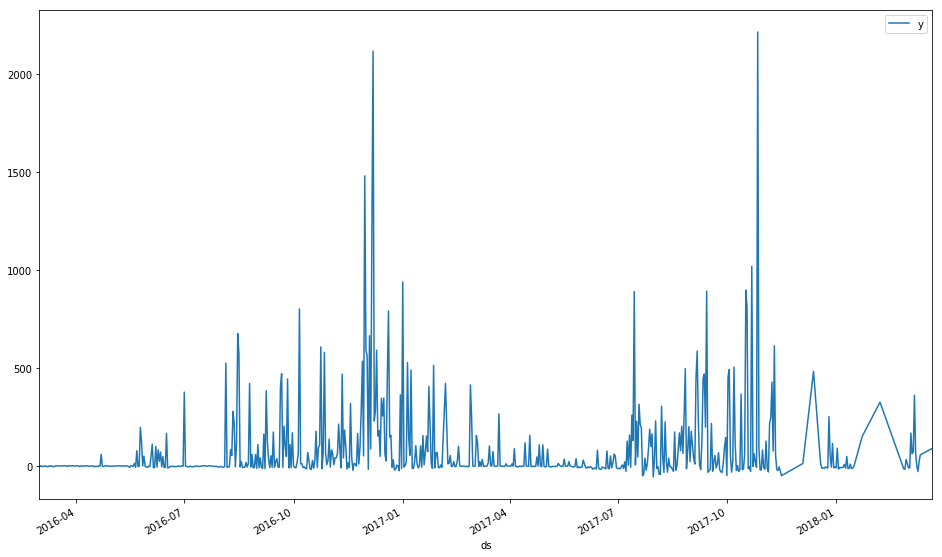

In [170]:
#isolate the first campaign
first_campaign_df = df.loc[df.Campaign == 'AW - Dynamic Search Ads Whole Site']

#create a custom metric,  revenue - cost
first_campaign_df['CPL'] = np.subtract(first_campaign_df.Revenue, first_campaign_df.Cost)

#format FB Prophet data frame,  date = ds,  metric = y
input = first_campaign_df.groupby('Date').agg({'CPL': 'sum'}).sort_values('Date').reset_index().rename(columns={'Date': 'ds', 'CPL': 'y'})

#plot input data frame
_ = input.plot(x='ds',figsize=(16,10))

### Calculate 7-day rolling average
Use STD() and MEAN()


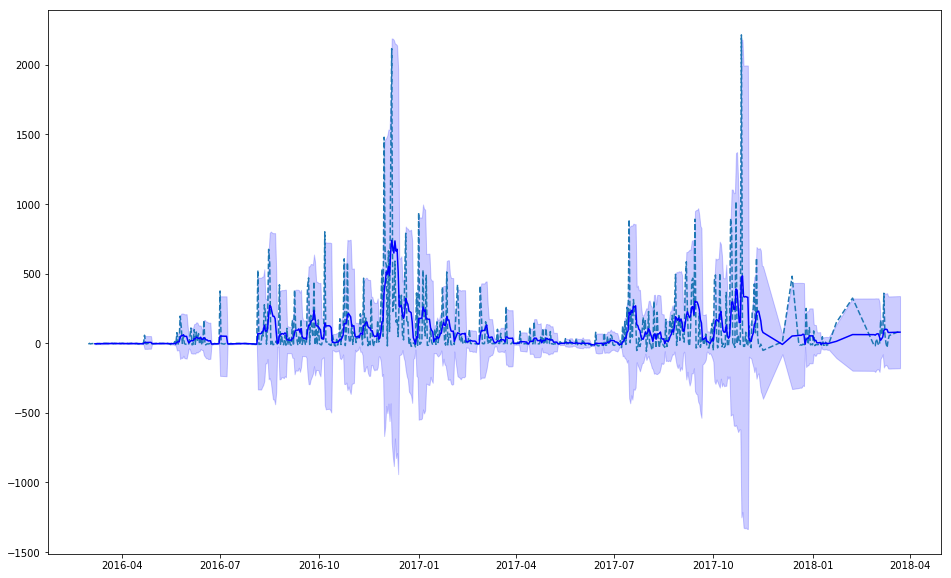

In [168]:
ma = input.rolling(7, on='ds').mean()
mstd = input.rolling(7, on='ds').std()
plt.figure(figsize=(16,10))
plt.plot(input.ds, input.y, '--')
plt.plot(ma.ds, ma.y, 'b')
plt.fill_between(mstd.ds, ma.y - 2 * mstd.y, ma.y + 2 * mstd.y,color='b', alpha=0.2)
plt.show()

### Build a 30-day forecast for the campaign

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


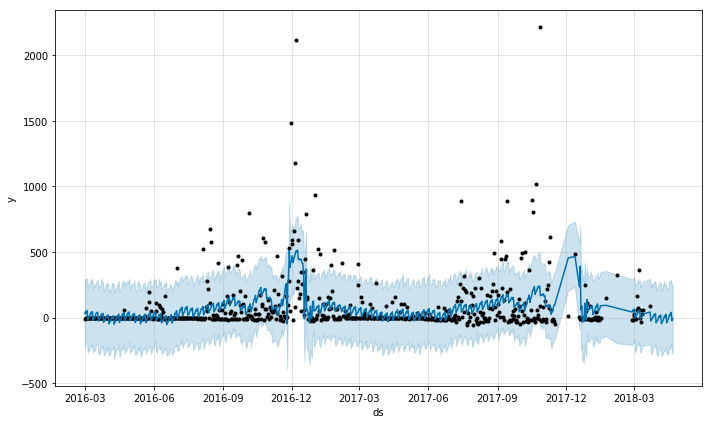

In [174]:
m = Prophet(holidays=holidays, mcmc_samples=50)
forecast = getForecast(m, input,holidays,30)

# Plot the model and forecast with additional trend analysis
from fbprophet.plot import add_changepoints_to_plot
_ = m.plot(forecast)

### Inspect the model components

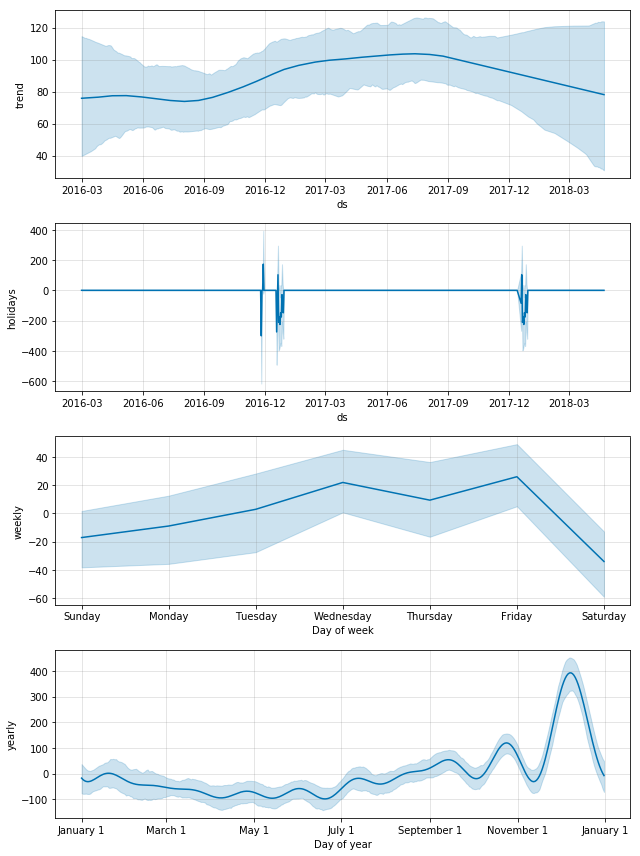

In [173]:
_ = m.plot_components(forecast)

### Filter outliers

In [0]:
combine = pd.concat([input.y,forecast],axis=1,sort='ds')
filter = combine.loc[(combine.y > combine.yhat_upper) | (combine.y < combine.yhat_lower)][['ds','y']]

### View outliers against rolling average

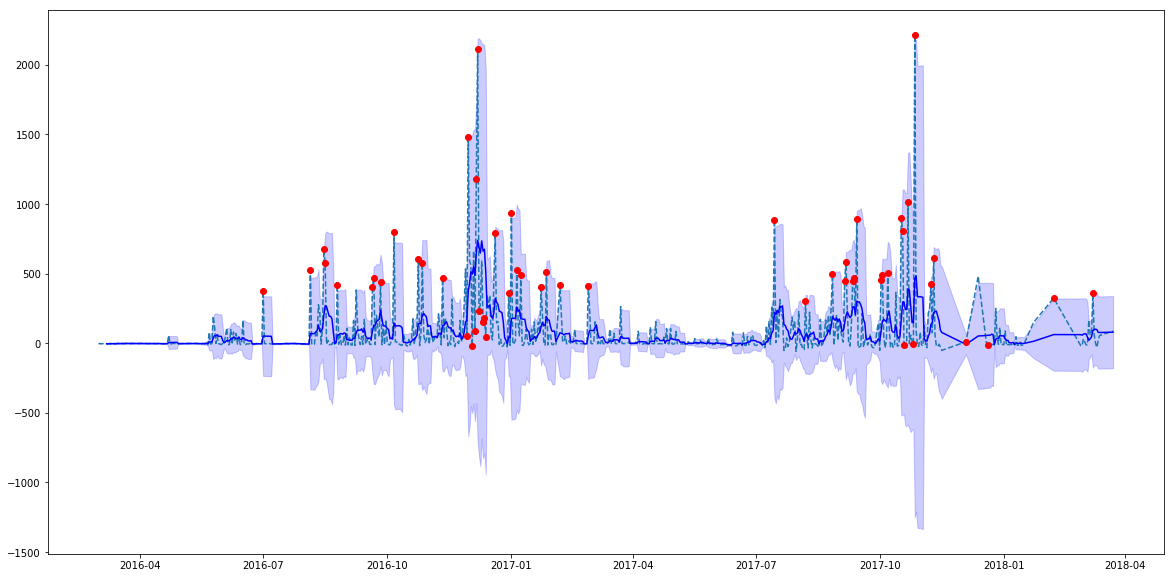

In [154]:
plt.figure(figsize=(20,10))
plt.plot(input.ds, input.y, '--')
plt.plot(ma.ds, ma.y, 'b')
plt.fill_between(mstd.ds, ma.y - 2 * mstd.y, ma.y + 2 * mstd.y,color='b', alpha=0.2)
plt.plot(filter.ds, filter.y,'o',c='r')
plt.show()

## Next Steps


*   Loop through all campaigns, model and build forecast
*   Fine tune `holidays` object to meet your needs
*   Save forecasts to BigQuery or Google Sheets
*   Evaluate new data against your forecasts
*   Replace Google Sheets with BigQuery query

